# Disaster building damage Prediction

In [1]:
import io
import tensorflow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
%cd "D:\Imarticus\stat\Disasters(Richter's Predictor - Modeling Earthquake Damage)"

D:\Imarticus\stat\Disasters(Richter's Predictor - Modeling Earthquake Damage)


In [3]:
dr_tr=pd.read_csv('train_values.csv')

In [4]:
dr_tt=pd.read_csv('test_values.csv')

In [5]:
dr_labels=pd.read_csv('train_labels.csv')

In [6]:
dr_tr=dr_tr.merge(dr_labels,on='building_id')

In [7]:
# We need to remove building_id in both train and test files because it's doesn't change prediction
dr_tr=dr_tr.drop(['building_id','geo_level_1_id','geo_level_2_id','geo_level_3_id'],axis=1)
dr_tt=dr_tt.drop(['building_id','geo_level_1_id','geo_level_2_id','geo_level_3_id'],axis=1)

# converting datatype from int to object

In [8]:
int_columns = ['count_floors_pre_eq','has_superstructure_adobe_mud','has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
       'has_superstructure_cement_mortar_stone','has_superstructure_mud_mortar_brick','has_superstructure_cement_mortar_brick',
        'has_superstructure_timber','has_superstructure_bamboo', 'has_superstructure_rc_non_engineered',
       'has_superstructure_rc_engineered', 'has_superstructure_other', 'count_families', 'has_secondary_use',
       'has_secondary_use_agriculture', 'has_secondary_use_hotel','has_secondary_use_rental', 'has_secondary_use_institution',
       'has_secondary_use_school', 'has_secondary_use_industry','has_secondary_use_health_post', 'has_secondary_use_gov_office',
       'has_secondary_use_use_police', 'has_secondary_use_other','damage_grade']

In [9]:
dr_tr[int_columns] = dr_tr[int_columns].astype('object')

In [10]:
int_columns_tt = ['count_floors_pre_eq','has_superstructure_adobe_mud','has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
       'has_superstructure_cement_mortar_stone','has_superstructure_mud_mortar_brick','has_superstructure_cement_mortar_brick',
        'has_superstructure_timber','has_superstructure_bamboo', 'has_superstructure_rc_non_engineered',
       'has_superstructure_rc_engineered', 'has_superstructure_other', 'count_families', 'has_secondary_use',
       'has_secondary_use_agriculture', 'has_secondary_use_hotel','has_secondary_use_rental', 'has_secondary_use_institution',
       'has_secondary_use_school', 'has_secondary_use_industry','has_secondary_use_health_post', 'has_secondary_use_gov_office',
       'has_secondary_use_use_police', 'has_secondary_use_other']

In [11]:
dr_tt[int_columns_tt] = dr_tt[int_columns_tt].astype('object')

# splitting into nnumcols and objcols

In [12]:
numcols=dr_tr.select_dtypes(include=np.number)
objcols=dr_tr.select_dtypes(include='object')

# Scaling

In [13]:
from sklearn.preprocessing import StandardScaler

In [14]:
sc=StandardScaler()

In [15]:
numcols_sc=sc.fit_transform(numcols)

In [16]:
numcols_sc=pd.DataFrame(numcols_sc,columns=numcols.columns)

# converting categorical data into numerical data with the help of label encoder

In [17]:
from sklearn.preprocessing import LabelEncoder

In [18]:
lb=LabelEncoder()

In [19]:
objcols=objcols.apply(LabelEncoder().fit_transform)

### test data

In [20]:
numcols_tt=dr_tt.select_dtypes(include=np.number)
objcols_tt=dr_tt.select_dtypes(include='object')

In [21]:
numcols_tt_sc=sc.fit_transform(numcols_tt)

In [22]:
numcols_tt_sc=pd.DataFrame(numcols_tt_sc,columns=numcols.columns)

In [23]:
objcols_tt=objcols_tt.apply(LabelEncoder().fit_transform)

In [24]:
combinedf=pd.concat([numcols_sc,objcols],axis=1)

In [25]:
dr_tt=pd.concat([numcols_tt_sc,objcols_tt],axis=1)

In [26]:
X=combinedf.drop('damage_grade',axis=1)
y=combinedf.damage_grade

In [46]:
Xtest=dr_tt.values
Xtest=Xtest.reshape(Xtest.shape[0], 1, Xtest.shape[1])

# TensorFlow RNN_LSTM Model Building

In [27]:
#RNN_LSTM
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout 
from keras.utils import to_categorical

In [28]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X.values, y, test_size=0.2, random_state=42)

In [33]:
# Reshape the data for LSTM (samples, time steps, features)
X_train_reshaped = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_reshaped = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
y_train=to_categorical(y_train)
y_test=to_categorical(y_test)

In [30]:
# Define the RNN architecture
model = Sequential()
model.add(LSTM(units=128, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
model.add(Dense(units=64,activation='relu'))
model.add(Dense(units=32,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=3, activation='softmax'))  # Output layer for multi-class classification
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               83968     
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 3)                 99        
                                                                 
Total params: 94403 (368.76 KB)
Trainable params: 94403 (368.76 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [31]:
# Train the model
model.fit(X_train_reshaped, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
5212/5212 [==============================] - 34s 6ms/step - loss: 0.8079 - accuracy: 0.5799 - val_loss: 0.7930 - val_accuracy: 0.5900
Epoch 2/50
5212/5212 [==============================] - 29s 6ms/step - loss: 0.7921 - accuracy: 0.5886 - val_loss: 0.7867 - val_accuracy: 0.5926
Epoch 3/50
5212/5212 [==============================] - 29s 6ms/step - loss: 0.7864 - accuracy: 0.5917 - val_loss: 0.7840 - val_accuracy: 0.5923
Epoch 4/50
5212/5212 [==============================] - 29s 6ms/step - loss: 0.7824 - accuracy: 0.5948 - val_loss: 0.7872 - val_accuracy: 0.5923
Epoch 5/50
5212/5212 [==============================] - 29s 6ms/step - loss: 0.7786 - accuracy: 0.5987 - val_loss: 0.7794 - val_accuracy: 0.5985
Epoch 6/50
5212/5212 [==============================] - 29s 6ms/step - loss: 0.7760 - accuracy: 0.6006 - val_loss: 0.7791 - val_accuracy: 0.6004
Epoch 7/50
5212/5212 [==============================] - 29s 6ms/step - loss: 0.7733 - accuracy: 0.6040 - val_loss: 0.7765 - val_ac

In [34]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test_reshaped, y_test)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

1629/1629 [==============================] - 6s 3ms/step - loss: 0.8236 - accuracy: 0.6025
Test Loss: 0.823607861995697
Test Accuracy: 0.6025018692016602


In [35]:
# Make predictions
predictions = model.predict(X_test_reshaped)

1629/1629 [==============================] - 5s 3ms/step


In [36]:
predictions=predictions.argmax(axis=1)

In [37]:
predictions

array([1, 1, 1, ..., 1, 2, 1], dtype=int64)

In [38]:
predictions=pd.DataFrame(predictions)
predictions.value_counts()

1    39000
2    10691
0     2430
Name: count, dtype: int64

<Axes: ylabel='count'>

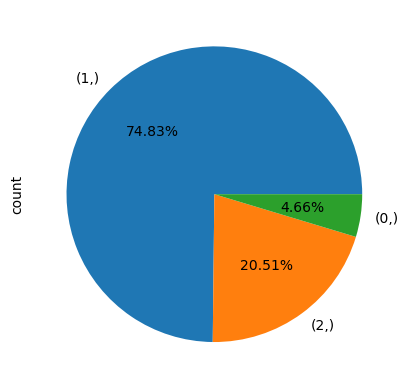

In [42]:
predictions.value_counts().plot(kind='pie',autopct='%0.2f%%')

In [49]:
test1=model.predict(Xtest)

2715/2715 [==============================] - 7s 3ms/step


In [50]:
test_pred=test1.argmax(axis=1)

In [51]:
test_pred=pd.DataFrame(test_pred)
test_pred.value_counts()

1    65331
2    17523
0     4014
Name: count, dtype: int64